# Imports

In [3]:
# Load NeuroKit and other useful packages
import neurokit2 as nk
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import pyxdf
from glob import glob

# Load Data

In [4]:
sub_files = glob('../../../Data/*/*.xdf')
sub_files

['../../../Data/sub-P5318014/sub-P5318014_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5182010/sub-P5182010_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5287460/sub-P5287460_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5447527/sub-P5447527_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-5958030/sub-P5958030_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5899288/sub-P5899288_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5813427/sub-P5813427_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5070899/sub-P5070899_ses-S001_task-CUNY_run-001_mobi.xdf',
 '../../../Data/sub-P5548165/sub-P5548165_ses-S001_task-CUNY_run-001_MOBI.xdf']

In [5]:
sub_number = 2
xdf_path = sub_files[sub_number]
data, header = pyxdf.load_xdf(xdf_path)
streams_collected = [stream['info']['name'][0] for stream in data]


'''
HELPERS
'''
def get_event_data(event, df, stim_df):
    return df.loc[(df.lsl_time_stamp >= stim_df.loc[stim_df.event == 'Onset_'+event, 'lsl_time_stamp'].values[0]) & 
                  (df.lsl_time_stamp <= stim_df.loc[stim_df.event == 'Offset_'+event, 'lsl_time_stamp'].values[0])]

def get_secs_between_triggers(trigger1, trigger2, stim_df):
    return stim_df.loc[stim_df.trigger == trigger1, 'time'].values[0] - stim_df.loc[stim_df.trigger == trigger2, 'time'].values[0]

                  
streams_collected

['Stimuli_Markers',
 'Tobii',
 'WebcamStream',
 'EGI NetAmp 0',
 'OpenSignals',
 'Microphone']

In [ ]:
PS = data[streams_collected.index('OpenSignals')]
column_labels = [PS['info']['desc'][0]['channels'][0]['channel'][i]['label'][0] for i in range(len(PS['info']['desc'][0]['channels'][0]['channel']))]
ps_df = pd.DataFrame(data=PS['time_series'], columns=column_labels)
ps_df['lsl_time_stamp'] = PS['time_stamps']
ps_df['time'] = (PS['time_stamps'] - PS['time_stamps'][0])/1000
ps_df

,nSeq,RESPIRATION0,fSpO21,fSpO22,%SpO23,lsl_time_stamp,time
0,618975.0,0.17633,0.50012,0.99115,82.0,468111.050621,0.000000
1,618976.0,0.17523,0.50013,0.99122,82.0,468111.052621,0.000002
2,618977.0,0.17432,0.50010,0.99115,82.0,468111.054621,0.000004
3,618978.0,0.17395,0.50008,0.99139,82.0,468111.056620,0.000006
4,618979.0,0.17267,0.50006,0.99126,82.0,468111.058620,0.000008
...,...,...,...,...,...,...,...
1130587,267419.0,0.01318,0.47252,0.92950,54.0,470395.489041,2.284438
1130588,267420.0,0.01355,0.47358,0.92937,54.0,470395.491040,2.284440
1130589,267421.0,0.01355,0.47303,0.92860,54.0,470395.493040,2.284442
1130590,267422.0,0.01392,0.47285,0.92921,54.0,470395.495040,2.284444


In [7]:
srate = PS['info']['effective_srate']

rsp_df = ps_df[['RESPIRATION0', 'lsl_time_stamp']].rename(columns={'RESPIRATION0': 'respiration'})
rsp = rsp_df.respiration
rsp

0          0.17633
1          0.17523
2          0.17432
3          0.17395
4          0.17267
            ...   
1130587    0.01318
1130588    0.01355
1130589    0.01355
1130590    0.01392
1130591    0.01392
Name: respiration, Length: 1130592, dtype: float32

# Visualize Respiration

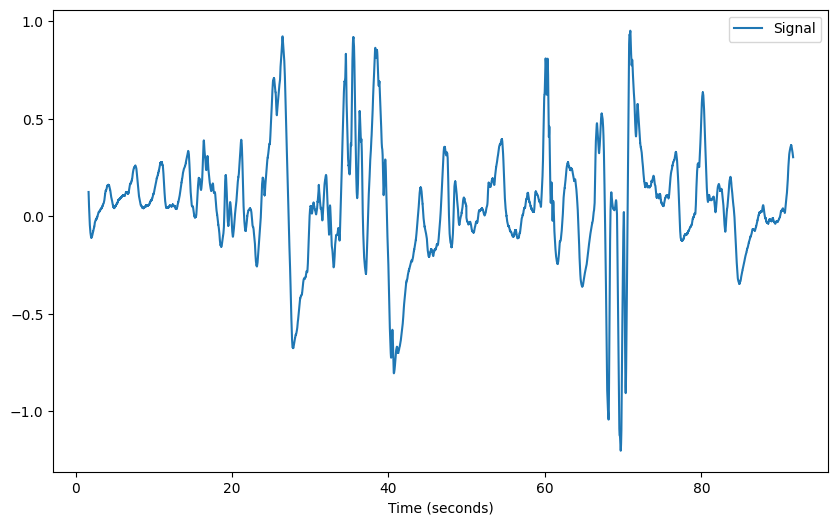

In [ ]:
# plot raw
# 100 seconds * 500 samps/second = 50000 samps
nk.signal_plot(rsp[1000:55000], sampling_rate=srate)

In [8]:
# Clean signal
cleaned = nk.rsp_clean(rsp, sampling_rate=srate, method = 'khodadad')

# Extract peaks
peaks_df, peaks_dict = nk.rsp_peaks(cleaned) # peaks_df: 1 where peaks and troughs are. dict: samples where peaks and troughs are
fixed_peaks = nk.rsp_fixpeaks(peaks_dict)
formatted = nk.signal_formatpeaks(fixed_peaks, desired_length=len(cleaned),peak_indices=fixed_peaks["RSP_Peaks"]) # what is this for

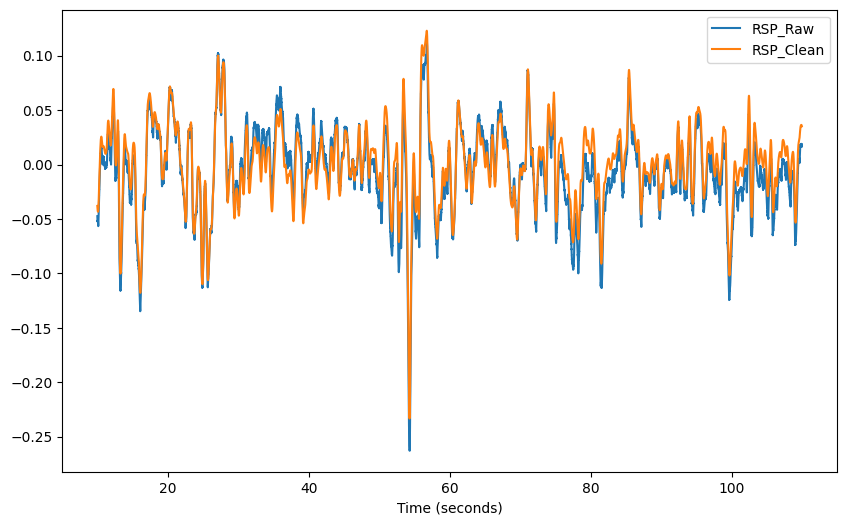

In [ ]:
plt.rcParams['figure.figsize'] = [10, 6]
nk.signal_plot(pd.DataFrame({"RSP_Raw": rsp[5000:55000], "RSP_Clean": cleaned[5000:55000]}), sampling_rate=srate) # subplots = True

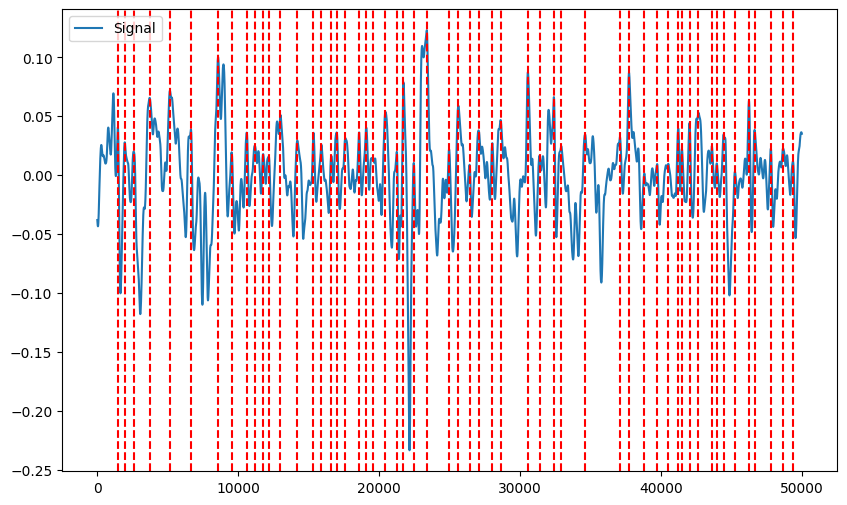

In [11]:
# mark peaks
short_peaks_df, short_peaks_dict = nk.rsp_peaks(cleaned[5000:55000]) # peaks_df: 1 where peaks and troughs are. dict: samples where peaks and troughs are
candidate_peaks = nk.events_plot(short_peaks_dict['RSP_Peaks'], cleaned[5000:55000])

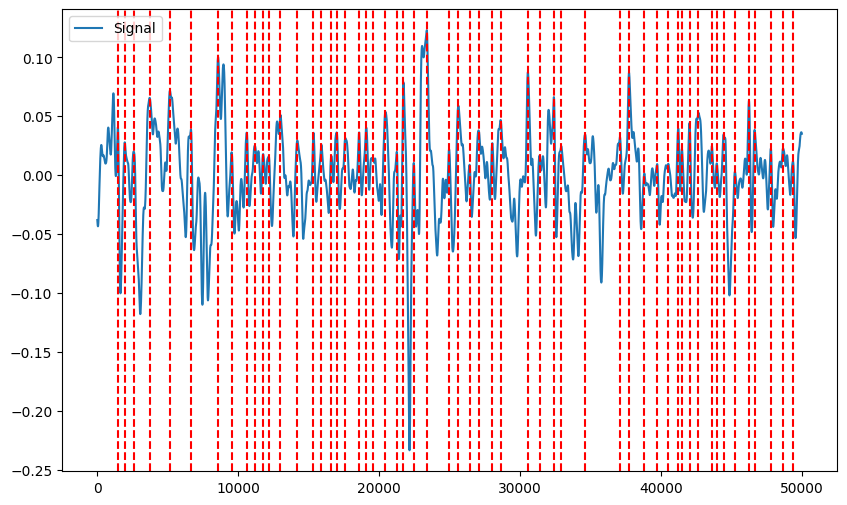

In [12]:
fixed_peaks = nk.rsp_fixpeaks(short_peaks_dict)
fixed_peaks_plot = nk.events_plot(fixed_peaks['RSP_Peaks'], cleaned[5000:55000])

In [ ]:
# get the values of the troughs
troughs_values = cleaned[5000:55000][short_peaks_df['RSP_Troughs'].to_numpy() == 1]
troughs_values

array([-0.00075611, -0.10020255, -0.02288476, -0.11783035, -0.01349679,
       -0.05255083, -0.10990114, -0.03495828, -0.04953162, -0.02616063,
       -0.01568463, -0.00724539, -0.04307681, -0.05203785, -0.05399769,
       -0.02253862, -0.03200734, -0.00590768, -0.0287358 , -0.01476737,
       -0.01700796, -0.0123187 , -0.03373308, -0.06146024, -0.0711607 ,
       -0.23338827, -0.04989438, -0.0681582 , -0.06479588, -0.02220448,
       -0.03532685, -0.02072747, -0.02023877, -0.06891486, -0.05123377,
       -0.02729752, -0.0525742 , -0.07151742, -0.09109857, -0.01569197,
       -0.04574238, -0.0168694 , -0.04197863, -0.01923162, -0.01320681,
       -0.02283039, -0.03603647, -0.03113313, -0.01072457, -0.01850961,
       -0.10195911, -0.01940054, -0.04823856, -0.02902617, -0.04381459,
       -0.01664741])

In [32]:
peaks_values = cleaned[5000:55000][short_peaks_df['RSP_Peaks'].to_numpy() == 1]
peaks_values

array([0.0406843 , 0.02793289, 0.02010407, 0.0656208 , 0.07172883,
       0.03884735, 0.10010514, 0.01942871, 0.03611533, 0.02506981,
       0.01790326, 0.01602355, 0.05105411, 0.0294696 , 0.03597308,
       0.02593291, 0.01635228, 0.03625966, 0.03143452, 0.03630058,
       0.04037012, 0.01493882, 0.05369488, 0.01981956, 0.07878069,
       0.01040571, 0.12296287, 0.02191682, 0.05893743, 0.00881359,
       0.03796825, 0.02716365, 0.04678441, 0.08743851, 0.01659388,
       0.06624931, 0.02462182, 0.03458689, 0.03248868, 0.0869537 ,
       0.00152808, 0.00940013, 0.00966387, 0.0396935 , 0.02210926,
       0.04434702, 0.05292329, 0.02477805, 0.010003  , 0.03468628,
       0.00300185, 0.06319458, 0.03839475, 0.0225782 , 0.0226711 ,
       0.01169712])

In [ ]:
breath_amplitude = peaks_values-troughs_values
np.mean(breath_amplitude)
np.std(breath_amplitude)

0.04628575719455801

# Respiration Rate

Text(0, 0.5, 'Breaths Per Minute')

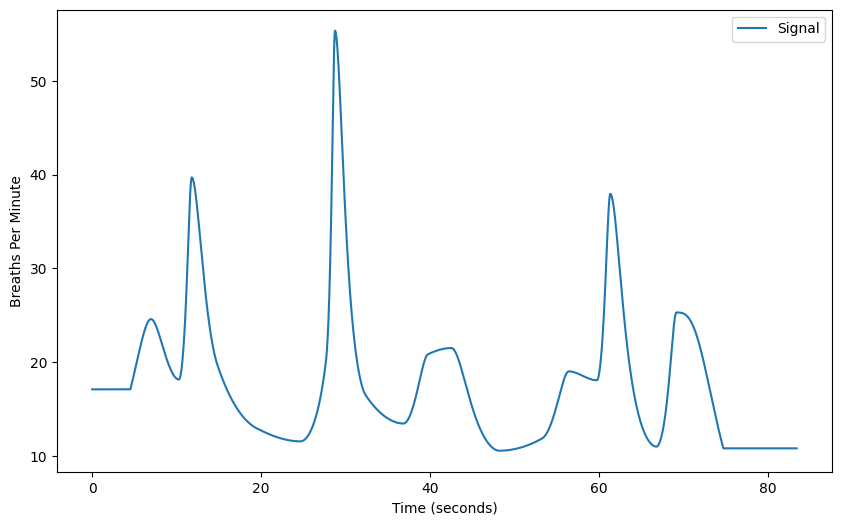

In [176]:
# Extract rate
rsp_rate = nk.rsp_rate(cleaned[5000:55000], short_peaks_dict, sampling_rate=srate)
# Visualize
nk.signal_plot(rsp_rate, sampling_rate=srate)
plt.ylabel('Breaths Per Minute')

In [1]:
rsp_rate

NameError: name 'rsp_rate' is not defined

# Analyze RRV

In [177]:
rrv = nk.rsp_rrv(rsp_rate, fixed_peaks, sampling_rate=srate)
rrv

,RRV_RMSSD,RRV_MeanBB,RRV_SDBB,RRV_SDSD,RRV_CVBB,RRV_CVSD,RRV_MedianBB,RRV_MadBB,RRV_MCVBB,RRV_VLF,RRV_LF,RRV_HF,RRV_LFHF,RRV_LFn,RRV_HFn,RRV_SD1,RRV_SD2,RRV_SD2SD1,RRV_ApEn,RRV_SampEn
0,2020.329746,3509.236075,1409.828556,2068.857834,0.401748,0.575718,3230.698801,1547.979407,0.479147,NaN,0.053473,0.003923,13.630573,NaN,NaN,1462.903403,1354.675882,0.926019,0.091859,inf


In [178]:
rrv # extract values from this for mean, sd
meanBB = rrv['RRV_MeanBB'][0] 
sdBB = rrv['RRV_SDBB'][0]

print(f"{meanBB:.8}, {sdBB:.8}")

print(f'Standard dev of Breath to Breath interval is {round(sdBB/meanBB * 100, 2)}% of Breath to Breath mean')

3509.2361, 1409.8286
Standard dev of Breath to Breath interval is 40.17% of Breath to Breath mean


# RSP_Plot

In [179]:
rsp_signals, info = nk.rsp_process(rsp, sampling_rate = srate)


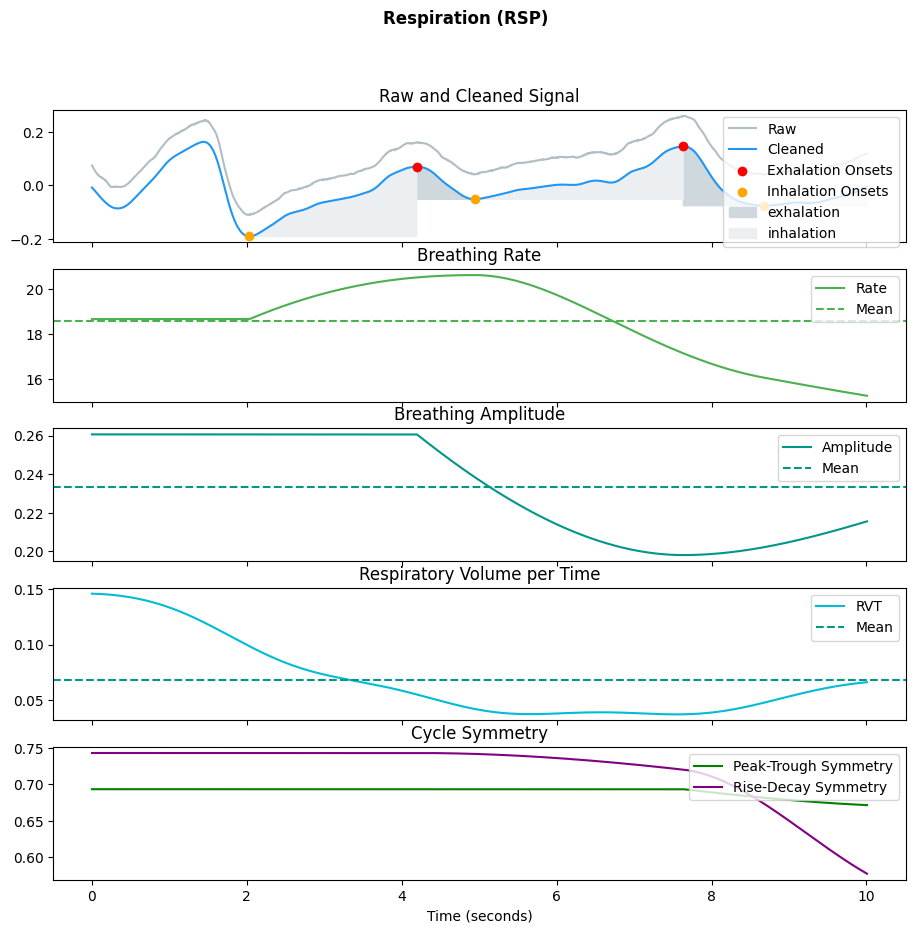

In [180]:
nk.rsp_plot(rsp_signals[:6000], info)
fig = plt.gcf()
ax = plt.gca()
fig.set_size_inches(11, 10) # Width, Height

plt.show()


# QC-- False Pos/Negs from Cleaning

In [181]:
# Raw Peak Detection
raw_peaks_df, raw_peaks_dict = nk.rsp_peaks(rsp) # peaks_df: 1 where peaks and troughs are. dict: samples where peaks and troughs are
# raw_fixed_peaks = nk.rsp_fixpeaks(raw_peaks_dict)

In [182]:
# Cleaned Peak Detection
cleaned_peaks_df, cleaned_peaks_dict = nk.rsp_peaks(cleaned) # peaks_df: 1 where peaks and troughs are. dict: samples where peaks and troughs are
# cleaned_fixed_peaks = nk.rsp_fixpeaks(cleaned_peaks_dict)

In [183]:
false_positive = ((raw_peaks_df['RSP_Peaks'] == 1) & (cleaned_peaks_df['RSP_Peaks'] == 0)).sum()
false_negative = ((raw_peaks_df['RSP_Peaks'] == 0) & (cleaned_peaks_df['RSP_Peaks'] == 1)).sum() 
true_positive = ((raw_peaks_df['RSP_Peaks'] == 1) & (cleaned_peaks_df['RSP_Peaks'] == 1)).sum()
true_negative = ((raw_peaks_df['RSP_Peaks'] == 0) & (cleaned_peaks_df['RSP_Peaks'] == 0)).sum()

### FN, FP rate #1
#### out of all the things that should have been positive, how many were incorrectly marked negative?

In [184]:
false_negative_rate1 = round(false_negative/((cleaned_peaks_df["RSP_Peaks"] == 1).sum()) * 100, 2) # same as round(false_negative/(false_negative+true_positive) * 100, 2)
false_negative_rate1 
# out of the however many peaks detected in cleaned, % were not detected in raw 

98.73

In [185]:
false_positive_rate1 = round(false_positive/((cleaned_peaks_df["RSP_Peaks"] == 0).sum()) * 100, 2)
false_positive_rate1 

# out of the things that should have been negatibe , % were incorrectly labeled as peaks in raw


0.03

### FN, FP rate #2
### out of all the things that raw marked as negative, how many were wrong (should have been positive)?

In [186]:
false_negative_rate2 = round(false_negative/((raw_peaks_df["RSP_Peaks"] == 0).sum()) * 100, 2)
false_negative_rate2

0.05

In [187]:
false_positive_rate2 = round(false_positive/((raw_peaks_df["RSP_Peaks"] == 1).sum()) * 100, 2)
false_positive_rate2 

97.76

In [188]:
print(f"false_positive: {false_positive} \n\
false_negative: {false_negative} \n\
true_positive: {true_positive} \n\
true_negative: {true_negative}")

false_positive: 480 
false_negative: 854 
true_positive: 11 
true_negative: 1666783


In [189]:
(raw_peaks_df["RSP_Peaks"] == 0).sum()

1667637

In [190]:
raw_peaks_df.sum()

RSP_Peaks      491
RSP_Troughs    491
dtype: int64

In [191]:
cleaned_peaks_df.sum()

RSP_Peaks      865
RSP_Troughs    865
dtype: int64

# QC- SNR

In [192]:
# raw signal
rsp_df = ps_df[['RESPIRATION0', 'lsl_time_stamp']].rename(columns={'RESPIRATION0': 'respiration'})
rsp = rsp_df.respiration

# cleaned signal
cleaned = nk.rsp_clean(rsp, sampling_rate=srate, method = 'khodadad')

# get power by np.var() on signal
signal_power = np.var(cleaned)

# Step 4: Estimate noise power (using residual noise after subtracting cleaned signal from noisy signal)
noise_signal = rsp - cleaned  # residual noise
noise_power = np.var(noise_signal)

snr = 10 * np.log10(signal_power / noise_power)
snr

8.845327626980682

In [193]:
# raw signal
rsp_df = ps_df[['RESPIRATION0', 'lsl_time_stamp']].rename(columns={'RESPIRATION0': 'respiration'})
rsp = rsp_df.respiration

# cleaned signal
cleaned = nk.rsp_clean(rsp, sampling_rate=srate, method = 'hampel')

# get power by np.var() on signal
signal_power = np.var(cleaned)

# Step 4: Estimate noise power (using residual noise after subtracting cleaned signal from noisy signal)
noise_signal = rsp - cleaned  # residual noise
noise_power = np.var(noise_signal)

snr = 10 * np.log10(signal_power / noise_power)
snr

/Users/camilla.strauss/anaconda3/envs/cuny_env/lib/python3.12/site-packages/neurokit2/rsp/rsp_clean.py:204: FutureWarning: Setting an item of incompatible dtype is deprecated and will raise an error in a future version of pandas. Value '[ 0.04395     0.12195     0.12195     0.12195     0.12195     0.12204
  0.12213     0.12222    -0.03021     0.19153     0.19153     0.19153
  0.19153     0.19153     0.19153     0.19153     0.19153    -0.043995
 -0.04102    -0.04102    -0.04102    -0.04102    -0.04102    -0.04102
 -0.04102    -0.04102    -0.04102    -0.04102    -0.04102    -0.04102
 -0.04102    -0.04102    -0.04102    -0.04102    -0.04102    -0.04102
 -0.04102    -0.04102    -0.15618999 -0.06573    -0.065685   -0.06555
 -0.06555    -0.06555    -0.065505   -0.07855    -0.07855    -0.21954
 -0.08267    -0.08267    -0.08267    -0.082625   -0.08267    -0.08267
 -0.08267    -0.28532499 -0.10995    -0.59500003 -0.59517998 -0.00595
 -0.00595    -0.00595    -0.00595    -0.00595    -0.00595    -

82.64622732519521

# Compare Cleaning Methods

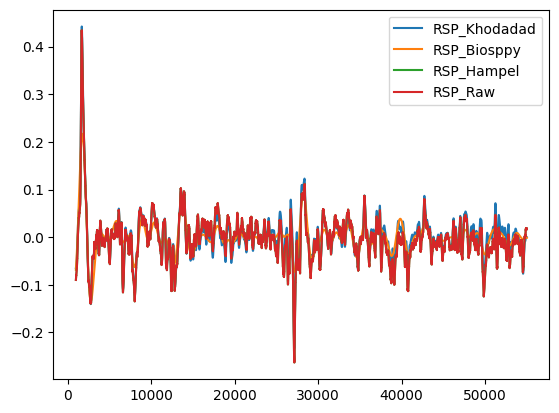

In [78]:
rsp = rsp[1000:55000]

signals = pd.DataFrame({
    "RSP_Khodadad": nk.rsp_clean(rsp, sampling_rate=srate, method="khodadad2018"),
    "RSP_Biosppy": nk.rsp_clean(rsp, sampling_rate=srate, method="biosppy"),
    "RSP_Hampel": nk.rsp_clean(rsp, sampling_rate=srate, method="hampel", threshold=3), 
    "RSP_Raw": rsp
})


ax = signals.plot() # alpha = 0.6
# ax.get_lines()[signals.columns.get_loc("RSP_Raw")].set_alpha(0.5) # adjust alpha for one column

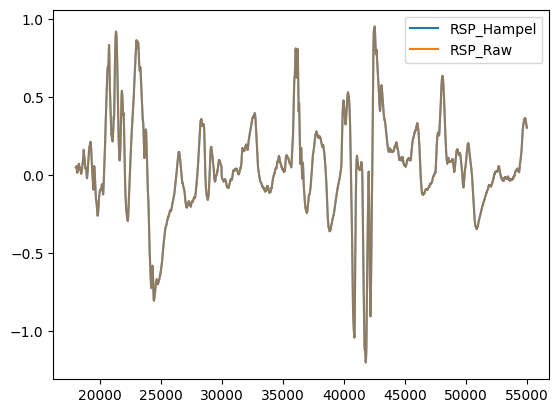

: 

In [ ]:
rsp = rsp[1000:55000]

signals2 = pd.DataFrame({
    "RSP_Hampel": nk.rsp_clean(rsp, sampling_rate=srate, method="hampel", threshold=3), 
    "RSP_Raw": rsp
})


ax = signals2.plot()
ax.get_lines()[signals2.columns.get_loc("RSP_Raw")].set_alpha(0.5)

In [79]:
# SNR khodadad 
# cleaned signal
cleaned_khodadad = signals['RSP_Khodadad']

# signal power
signal_power_khodadad = np.var(cleaned_khodadad)

# noise signal
noise_signal_khodadad = rsp - cleaned_khodadad

# noise power
noise_power_khodadad = np.var(noise_signal_khodadad)

# snr
snr_khodadad = 10 * np.log10(signal_power_khodadad / noise_power_khodadad)
snr_khodadad

12.091032873693887

In [81]:
# SNR biosppy 
# cleaned signal
cleaned_biosppy = signals['RSP_Biosppy']

# signal power
signal_power_biosppy = np.var(cleaned_biosppy)

# noise signal
noise_signal_biosppy = rsp - cleaned_biosppy

# noise power
noise_power_biosppy = np.var(noise_signal_biosppy)

# snr
snr_biosppy = 10 * np.log10(signal_power_biosppy / noise_power_biosppy)
snr_biosppy


0.5700334890672937

In [82]:
# SNR hampel 
# cleaned signal
cleaned_hampel = signals['RSP_Hampel']

# signal power
signal_power_hampel = np.var(cleaned_hampel)

# noise signal
noise_signal_hampel = rsp - cleaned_hampel

# noise power
noise_power_hampel = np.var(noise_signal_hampel)

# snr
if noise_power_hampel == 0:
        snr_hampel = "no noise"
else:
    snr_hampel = 10 * np.log10(signal_power_hampel / noise_power_hampel)
snr_hampel


'no noise'

In [84]:
compare_snr = {'khodadad': snr_khodadad,
'biosppy': snr_biosppy,
'hampel': snr_hampel}

subject = sub_files[sub_number].split('/')[4].split('-')[1]
print("sub", subject, "#", sub_number)
compare_snr

sub P5287460 # 2


{'khodadad': 12.091032873693887,
 'biosppy': 0.5700334890672937,
 'hampel': 'no noise'}

In [ ]:
# effective sampling rate
srate = PS['info']['effective_srate']
srate

500.0724956736303